# STEP 1 - OFFLINE ANALYSIS (TRAINING)

In [1]:
import os
from IntelliMaint.eda import ExploratoryAnalysis
from IntelliMaint.feature_engineering import TimeDomain
from IntelliMaint.data_analysis import SOM
from IntelliMaint.health_assessment import HealthIndicator
from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.rul_models import GPRDegradationModel
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
import pickle as pkl

/home/iptlp0032/intellipredikt/tfvenv/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


# Data Acquisition (DA)

In [2]:
files = sorted(glob.glob('data/bearing_data/3rd_test/txt/200*'))[4000:]

# Data Manipulation (DM)

### Feature Extraction

In [3]:
a = []
td = TimeDomain()
ber=1
for i in range(len(files)):
    df = pd.read_csv(files[i],sep='\t',header = None, names=(['0','1','2','3'])) 
    c = np.reshape([td.get_rms(df[str(ber)]),td.get_kurtosis(df[str(ber)]),\
        td.get_mean(df[str(ber)]),td.get_crestfactor(df[str(ber)]),\
        td.get_skewness(df[str(ber)]),td.get_variance(df[str(ber)])],\
        (-1,6))
    a.append(c)
    fea=np.array(a).reshape(-1,6)
       
out=pd.DataFrame(fea,columns=['rms','kurtosis','mean','crestfactor','skewness','variance'])
out['File']=files
out.set_index('File', inplace = True)
out.to_csv('data/temp/Bearing_1_3rd.csv')
del out

In [4]:
data = pd.read_csv('data/temp/Bearing_1_3rd.csv')

### Exploratory Data Analysis

------------------------------------
Performing Exploratory Data Analysis
------------------------------------

The train data has 2324 rows and 7 columns

Descriptive Statistics
----------------------
               rms     kurtosis         mean  crestfactor     skewness  \
count  2324.000000  2324.000000  2324.000000  2324.000000  2324.000000   
mean      0.081907     0.142302    -0.002029     4.977831     0.112194   
std       0.018320     0.090649     0.001093     0.639851     0.041515   
min       0.002789    -0.460504    -0.022389     2.509546    -0.303353   
25%       0.076681     0.089848    -0.002352     4.531791     0.094931   
50%       0.077335     0.141819    -0.002031     4.871865     0.114447   
75%       0.078239     0.198384    -0.001749     5.355837     0.133418   
max       0.272873     0.658376     0.024520     8.718905     0.906423   

          variance  
count  2324.000000  
mean      0.007039  
std       0.004946  
min       0.000002  
25%       0.005874  
50%  

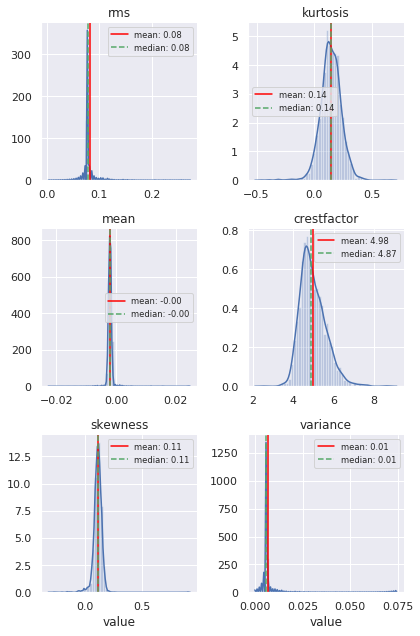

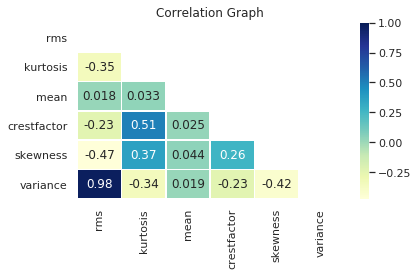

(               rms     kurtosis         mean  crestfactor     skewness  \
 count  2324.000000  2324.000000  2324.000000  2324.000000  2324.000000   
 mean      0.081907     0.142302    -0.002029     4.977831     0.112194   
 std       0.018320     0.090649     0.001093     0.639851     0.041515   
 min       0.002789    -0.460504    -0.022389     2.509546    -0.303353   
 25%       0.076681     0.089848    -0.002352     4.531791     0.094931   
 50%       0.077335     0.141819    -0.002031     4.871865     0.114447   
 75%       0.078239     0.198384    -0.001749     5.355837     0.133418   
 max       0.272873     0.658376     0.024520     8.718905     0.906423   
 
           variance  
 count  2324.000000  
 mean      0.007039  
 std       0.004946  
 min       0.000002  
 25%       0.005874  
 50%       0.005975  
 75%       0.006114  
 max       0.074457  ,              Skewness_Value
 rms                5.481120
 kurtosis          -0.427157
 mean               6.147547
 crestfac

In [5]:
e = ExploratoryAnalysis(data)
e.perform_eda()

In [6]:
data = np.array(data)[:, 1:]
f1, f2, f3, f4, f5, f6 = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5]

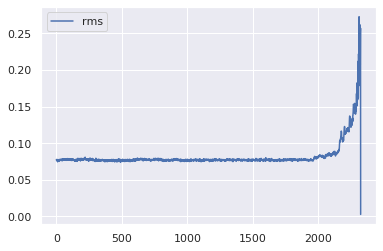

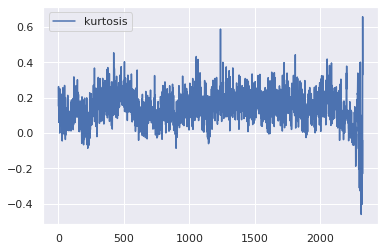

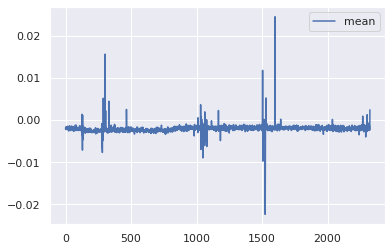

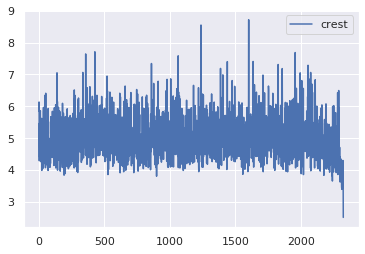

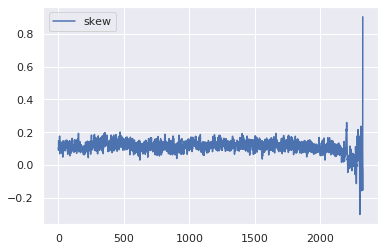

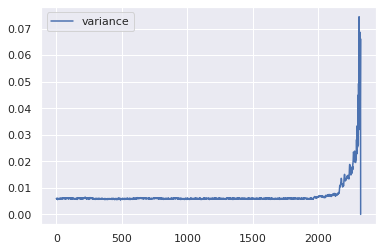

In [7]:
plt.plot(f1, label='rms')
plt.legend()
plt.show()
plt.plot(f2, label='kurtosis')
plt.legend()
plt.show()
plt.plot(f3, label='mean')
plt.legend()
plt.show()
plt.plot(f4, label='crest')
plt.legend()
plt.show()
plt.plot(f5, label='skew')
plt.legend()
plt.show()
plt.plot(f6, label='variance')
plt.legend()
plt.show()

### Feature Reduction (SOM)

In [8]:
# use rms, kurtosis, crest for fusion
data = np.concatenate((f1.reshape(len(f1), 1), f2.reshape(len(f2), 1), f4.reshape(len(f4), 1)), axis=1)
train_som = data[:1000]
test_som = data
da = SOM()
som, scaler = da.train(train_som)
som_error = da.predict(som, test_som, scaler) # on full data

# rms, kurtosis, crest, error
data = np.concatenate((data, som_error.reshape(len(som_error), 1)), axis=1)

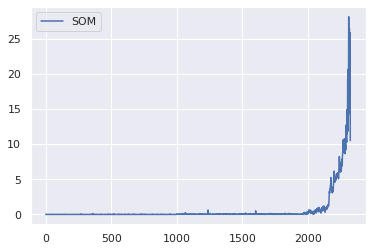

In [9]:
plt.plot(data[:, 3], label='SOM')
plt.legend()
plt.show()


### Feature Ranking

In [10]:
ad = HealthIndicator()
score = ad.computeHIScore(data)
# col = np.argmax(score)
col = 3

hi = data[:, col]

print ('Selected HI :', col)

Selected HI : 3


### Transform the HI into strangeness measure

In [11]:
hi_train = hi[:1000]
hi_test = hi
ad = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
ad.train_cosmo(hi_train)

hi_test = pd.DataFrame(hi_test)
strangeness, _ = ad.test_cosmo(hi_test)
strangeness = strangeness.squeeze()

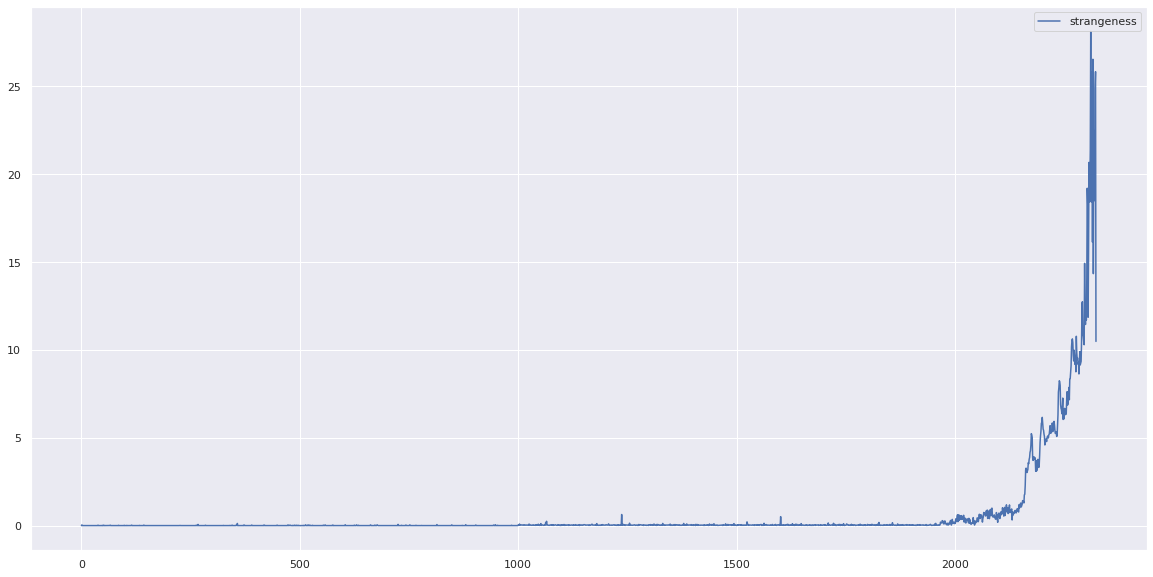

In [12]:
plt.figure(figsize=(20,10))
plt.plot(strangeness, label='strangeness')
plt.legend()
plt.show()

# Save the analysis information

In [13]:
analysis_info = {}
analysis_info['extracted_features'] = ['rms', 'kurtosis', 'crest', 'error']
analysis_info['normal_data_pts'] = 1000
analysis_info['prediction_horizon'] = 100
analysis_info['health_indicator'] = analysis_info['extracted_features'][col]
analysis_info['min_continuous_deg_pts'] = 10
analysis_info['incipient_fault_threshold'] = 2.0
analysis_info['failure_threshold'] = 6.0

print ('Saving Analysis Information in data/temp/analysis_info.pkl')
f = open("data/temp/analysis_info.pkl", "wb")
pkl.dump(analysis_info, f)
f.close()

Saving Analysis Information in data/temp/analysis_info.pkl


# STEP 2 - REALTIME ANALYSIS (TESTING)

In [14]:
analysis_info = pd.read_pickle('data/temp/analysis_info.pkl')
prediction_horizon = analysis_info['prediction_horizon']
normal_data_pts = analysis_info['normal_data_pts']
min_continuous_deg_pts = analysis_info['min_continuous_deg_pts']
incipient_fault_threshold = analysis_info['incipient_fault_threshold']
failure_threshold = analysis_info['failure_threshold']

# Read the data

In [15]:
files = sorted(glob.glob('data/bearing_data/3rd_test/txt/200*'))[4000:]
data_list = []
td = TimeDomain()
test_bearing_idx = 0

# Stream through the first 1000 data points (normal)

In [16]:
# wait for initial 1000 observations
i = 0
while (i <= normal_data_pts):
    df = pd.read_csv(files[i],sep='\t',header = None, names=(['0','1','2','3'])) 
    temp = np.reshape([td.get_rms(df[str(test_bearing_idx)]),\
        td.get_kurtosis(df[str(test_bearing_idx)]),\
        td.get_crestfactor(df[str(test_bearing_idx)])],\
        (-1,3))
    data_list.append(temp)
    i += 1

initial_features = np.array(data_list).reshape(-1,3)
print ("Done. 1000 samples.")

Done. 1000 samples.


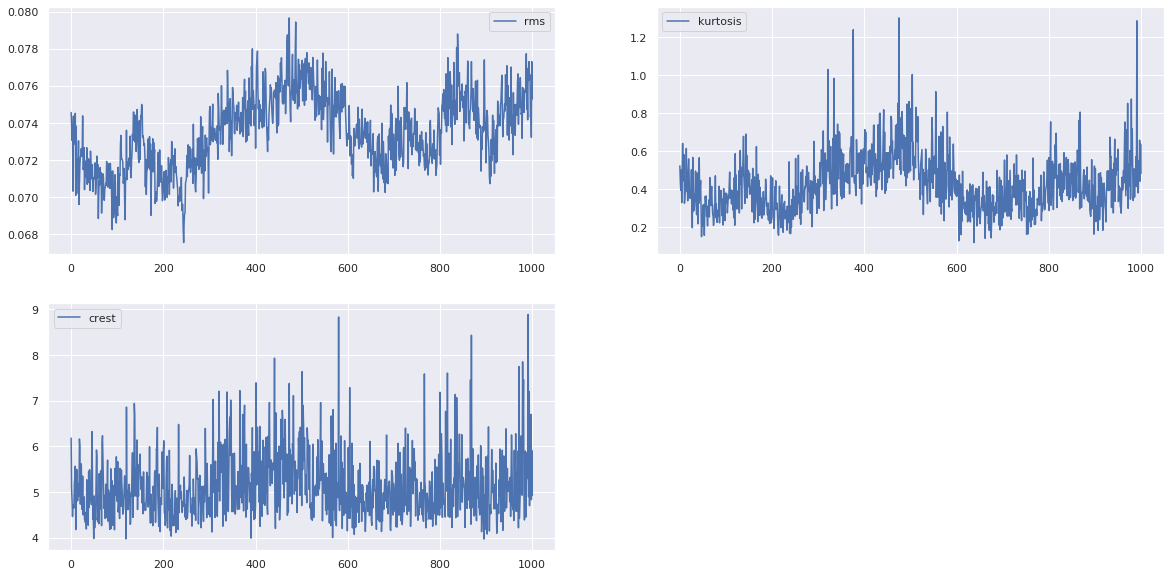

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(initial_features[:, 0], label='rms')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(initial_features[:, 1], label='kurtosis')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(initial_features[:, 2], label='crest')
plt.legend()
plt.show()

In [18]:
# use rms, kurtosis, crest for fusion
da = SOM()
som, scaler = da.train(initial_features)
train_error = da.predict(som, initial_features, scaler)

ad = AnomalyDetection()
train_error = pd.DataFrame(train_error)
ad.train_cosmo(train_error)

# Health Assessment (HA)

In [20]:
# #-----------Anomaly Detection & Health Assessment--------------
initial_deg_pts = []
iter_= 0
tracker = 0
flag = False
continuously_deg_pts = 0
deg_start_idx = 0
data_till_incipient = []
for i in range(normal_data_pts+1, len(files)):
    df = pd.read_csv(files[i],sep='\t',header = None, names=(['0','1','2','3'])) 
    fea = np.reshape([td.get_rms(df[str(test_bearing_idx)]),\
        td.get_kurtosis(df[str(test_bearing_idx)]),\
        td.get_crestfactor(df[str(test_bearing_idx)])],(-1,3))

    error = da.predict(som, fea, scaler).reshape(1, 1)
    error = pd.DataFrame(error)
    strangeness, _ = ad.test_cosmo(error)
    strangeness = strangeness.squeeze()
    print ("\rThe strangeness value is : {} | STATUS : NORMAL | ACTION : NO ACTION".format(strangeness), end='')
    data_till_incipient.append(strangeness)
    # check for continuous degradation
    if (strangeness >= incipient_fault_threshold) and (not flag):
        deg_start_idx = i
        iter_ += 1
        flag = True
    elif (strangeness >= incipient_fault_threshold):
        iter_ += 1

    if (flag):
        tracker += 1

        if (iter_ / tracker == 1.0):
            continuously_deg_pts += 1
            initial_deg_pts.append(strangeness)
        else:
            initial_deg_pts = []
            continuously_deg_pts = 0
            iter_ = 0
            tracker = 0
            flag = False

    if (continuously_deg_pts >= min_continuous_deg_pts):
        break
print ("\nIncipient Threshold {} reached! Beginning RUL estimation ... ".format(incipient_fault_threshold))

The strangeness value is : 2.434194905604985 | STATUS : NORMAL | ACTION : NO ACTIONNNNN
Incipient Threshold 2.0 reached! Beginning RUL estimation ... 


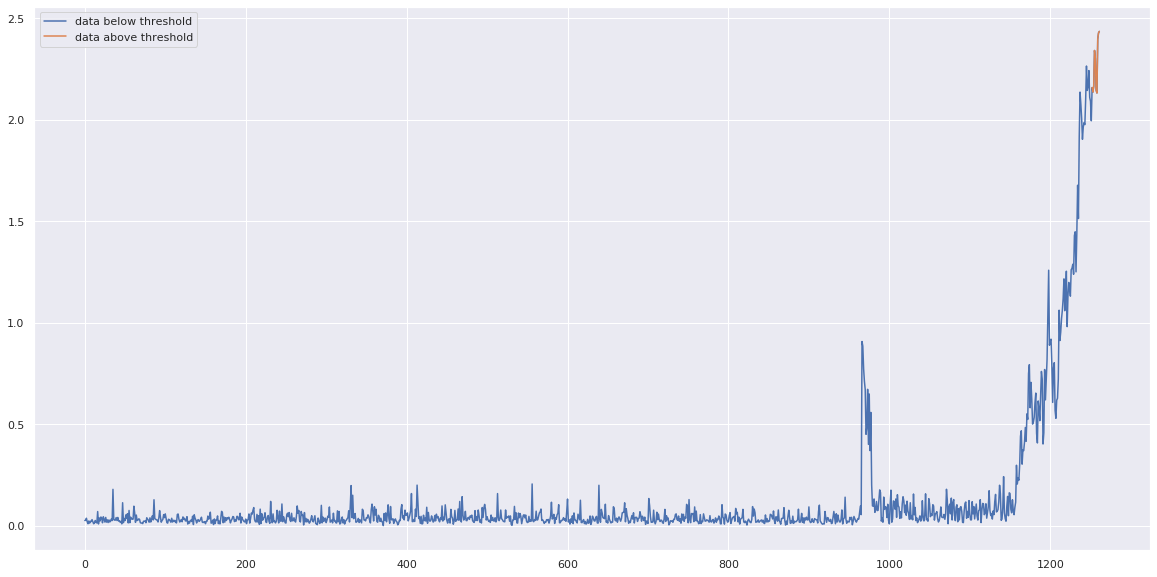

In [21]:
plt.figure(figsize=(20,10))
plt.plot(data_till_incipient, label='data below threshold')
plt.plot([i for i in range(len(data_till_incipient) - min_continuous_deg_pts, len(data_till_incipient))], initial_deg_pts, label='data above threshold')
plt.legend()
plt.show()

# Prognostics Assessment (PA) - RUL prediction

(10, 1) (10, 1)
The strangeness value is : 5.493352039203558 | STATUS : FAILURE | ACTION : REPLACE INSPECT                           

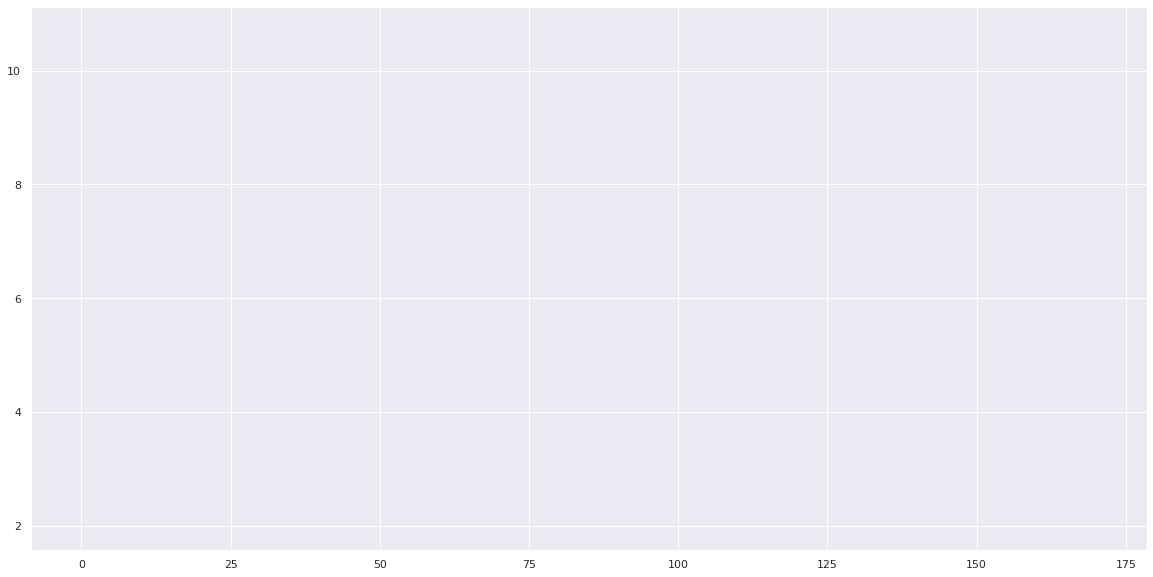

In [28]:
from IPython.display import HTML
from celluloid import Camera

fig = plt.figure(figsize=(20, 10))
# plt.axes(xlim=(0, 200), ylim=(-8, 8))
camera = Camera(fig)
# #-----------RUL Estimation-------------------------------------
hi_raw = np.array(initial_deg_pts).reshape(len(initial_deg_pts), 1)
rul_model = GPRDegradationModel(hi_raw, failure_threshold, order=1)
l = 0

for i in range(deg_start_idx+min_continuous_deg_pts, len(files)):
    df = pd.read_csv(files[i],sep='\t',header = None, names=(['0','1','2','3'])) 
    fea = np.reshape([td.get_rms(df[str(test_bearing_idx)]),\
        td.get_kurtosis(df[str(test_bearing_idx)]),\
        td.get_crestfactor(df[str(test_bearing_idx)])],(-1,3))

    error = da.predict(som, fea, scaler).reshape(1, 1)
    error = pd.DataFrame(error)
    strangeness, _ = ad.test_cosmo(error)
    strangeness = strangeness.squeeze()
    hi_raw = np.concatenate((hi_raw, strangeness.reshape(-1, 1)), axis=0)

    # predict next prediction_horizon intervals
    Yp, Vp, rul = rul_model.predict(np.array([k for k in range(min_continuous_deg_pts+l, min_continuous_deg_pts+l+prediction_horizon)]).reshape(prediction_horizon, 1))
    
    # update the model
    x = np.array([k for k in range(len(hi_raw))]).reshape(len(hi_raw), 1)
    y = hi_raw
    rul_model.update(x, y)
#     if (rul and (strangeness > incipient_ or rul == 71 or rul == 0)):
    
    if (rul and rul > 0):
        plt.text(20, 8.0, "Remaining Useful Life (RUL) : "+str(round(rul/6.0, 2))+" hours | ACTION : INSPECT")
        print (" \rThe strangeness value is : {} | STATUS : INCIPIENT FAULT | ACTION : INSPECT".format(strangeness), end='')
    if (rul and rul < 0):
        plt.text(20, 8.0, "Remaining Useful Life (RUL) : 0 hours | ACTION : REPLACE")
        print (" \rThe strangeness value is : {} | STATUS : FAILURE | ACTION : REPLACE".format(strangeness), end='')
        
    plt.plot([k for k in range(l, l+prediction_horizon)], Yp)
    plt.plot(hi_raw[min_continuous_deg_pts:])
    plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp + Vp, color='k', alpha=.5)
    plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp - Vp, color='k', alpha=.5)
    plt.plot([failure_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ff0000')
    plt.plot([incipient_fault_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ffff00')
    l += 1
    camera.snap()
animation = camera.animate()   
HTML(animation.to_html5_video())
# plt.show()

# Snapshot of RUL prediction

(10, 1) (10, 1)


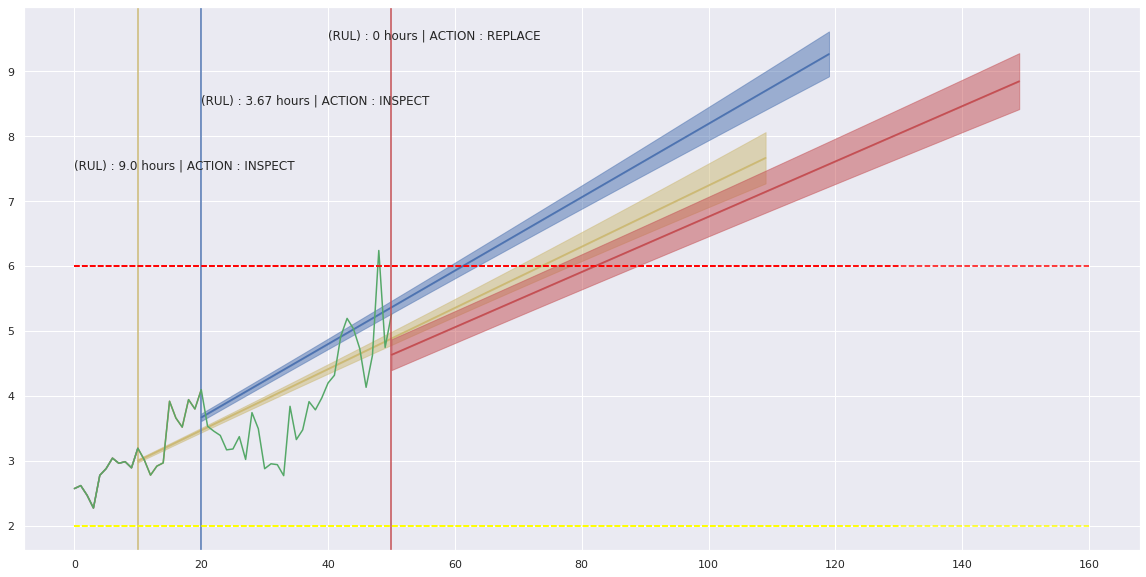

In [66]:
fig = plt.figure(figsize=(20, 10))

# #-----------RUL Estimation-------------------------------------
hi_raw = np.array(initial_deg_pts).reshape(len(initial_deg_pts), 1)
rul_model = GPRDegradationModel(hi_raw, failure_threshold, order=1)
l = 0

for i in range(deg_start_idx+min_continuous_deg_pts, len(files)):
    df = pd.read_csv(files[i],sep='\t',header = None, names=(['0','1','2','3'])) 
    fea = np.reshape([td.get_rms(df[str(test_bearing_idx)]),\
        td.get_kurtosis(df[str(test_bearing_idx)]),\
        td.get_crestfactor(df[str(test_bearing_idx)])],(-1,3))

    error = da.predict(som, fea, scaler).reshape(1, 1)
    error = pd.DataFrame(error)
    strangeness, _ = ad.test_cosmo(error)
    hi_raw = np.concatenate((hi_raw, strangeness.reshape(-1, 1)), axis=0)

    # predict next prediction_horizon intervals
    Yp, Vp, rul = rul_model.predict(np.array([k for k in range(min_continuous_deg_pts+l, min_continuous_deg_pts+l+prediction_horizon)]).reshape(prediction_horizon, 1))
    
    # update the model
    x = np.array([k for k in range(len(hi_raw))]).reshape(len(hi_raw), 1)
    y = hi_raw
    rul_model.update(x, y)
    if (i == deg_start_idx+min_continuous_deg_pts+10): # 
        if (rul and rul > 0):
            plt.text(0, 7.5, "(RUL) : "+str(round(rul/6.0, 2))+" hours | ACTION : INSPECT")
        if (rul and rul < 0):
            plt.text(0, 7.5, "(RUL) : 0 hours | ACTION : REPLACE")
        plt.plot([k for k in range(l, l+prediction_horizon)], Yp, color='y')
        plt.plot(hi_raw[min_continuous_deg_pts:])
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp + Vp, color='y', alpha=.5)
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp - Vp, color='y', alpha=.5)
        plt.plot([failure_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ff0000')
        plt.plot([incipient_fault_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ffff00')
        plt.axvline(x=l, c='y')
    # -----------------------
    if (i == deg_start_idx+min_continuous_deg_pts+20): # 
        if (rul and rul > 0):
            plt.text(20, 8.5, "(RUL) : "+str(round(rul/6.0, 2))+" hours | ACTION : INSPECT")
        if (rul and rul < 0):
            plt.text(20, 8.5, "(RUL) : 0 hours | ACTION : REPLACE")
        plt.plot([k for k in range(l, l+prediction_horizon)], Yp, color='b')
        plt.plot(hi_raw[min_continuous_deg_pts:])
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp + Vp, color='b', alpha=.5)
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp - Vp, color='b', alpha=.5)
        plt.plot([failure_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ff0000')
        plt.plot([incipient_fault_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ffff00')
        plt.axvline(x=l, c='b')
    # ------------------------------
    if (i == deg_start_idx+min_continuous_deg_pts+50): # 
        if (rul and rul > 0):
            plt.text(40, 9.5, "(RUL) : "+str(round(rul/6.0, 2))+" hours | ACTION : INSPECT")
        if (rul and rul < 0):
            plt.text(40, 9.5, "(RUL) : 0 hours | ACTION : REPLACE")
        plt.plot([k for k in range(l, l+prediction_horizon)], Yp, color='r')
        plt.plot(hi_raw[min_continuous_deg_pts:])
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp + Vp, color='r', alpha=.5)
        plt.fill_between(np.array([k for k in range(l, l+prediction_horizon)]).reshape(len(Yp), 1).squeeze(), Yp, Yp - Vp, color='r', alpha=.5)
        plt.plot([failure_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ff0000')
        plt.plot([incipient_fault_threshold for i in range(len(Yp)+len(hi_raw))], linestyle='dashed', color='#ffff00')
        plt.axvline(x=l, c='r')
    
    l += 1
# plt.legend()
plt.show()